In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
df = pd.read_csv('../../Dataset/Palladium.csv')
df = df.reset_index()['Close']
df

0       1067.5
1       1096.0
2       1088.0
3       1102.5
4       1091.5
         ...  
2339     975.5
2340     968.0
2341     950.5
2342     914.5
2343     914.5
Name: Close, Length: 2344, dtype: float64

In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
25/25 [==============================] - 8s 126ms/step - loss: 0.1251 - val_loss: 0.0595
Epoch 2/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0154 - val_loss: 0.0127
Epoch 3/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 4/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0011 - val_loss: 4.2667e-04
Epoch 6/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0011 - val_loss: 4.2787e-04
Epoch 7/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0010 - val_loss: 4.3411e-04
Epoch 8/100
25/25 [==============================] - 2s 86ms/step - loss: 9.6623e-04 - val_loss: 4.0256e-04
Epoch 9/100
25/25 [==============================] - 2s 91ms/step - loss: 9.3581e-04 - val_loss: 3.8198e-04
Epoch 10/100
25/25 [==============================] - 2s 95ms/step - l

In [10]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

19/19 [==============================] - 6s 27ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred = scaler.inverse_transform(y_pred)

In [12]:
train_size1 = int(0.7 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [13]:
# 12. Đánh giá độ chính xác thuật toán
# Tính MSE - Mean Squared Error - Sai số bình phương trung bình
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred) 
print('Testing MSE:', test_mse)

# Tính RMSE - Root Mean Squared Error - Sai số bình phương trung bình
test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

# Tính MAPE - Mean Absolute Percentage Error - Tỷ lệ phần trăm sai số tuyệt đối trung bình
test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 1941.3185984324023
Testing RMSE: 44.060397166076505
Testing MAPE: 0.023802165927319405


In [14]:
# 13. Tạo hàm dự báo
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0
    
    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    return lst_output

In [15]:
# Dự đoán 30, 60, 90 ngày tiếp theo
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

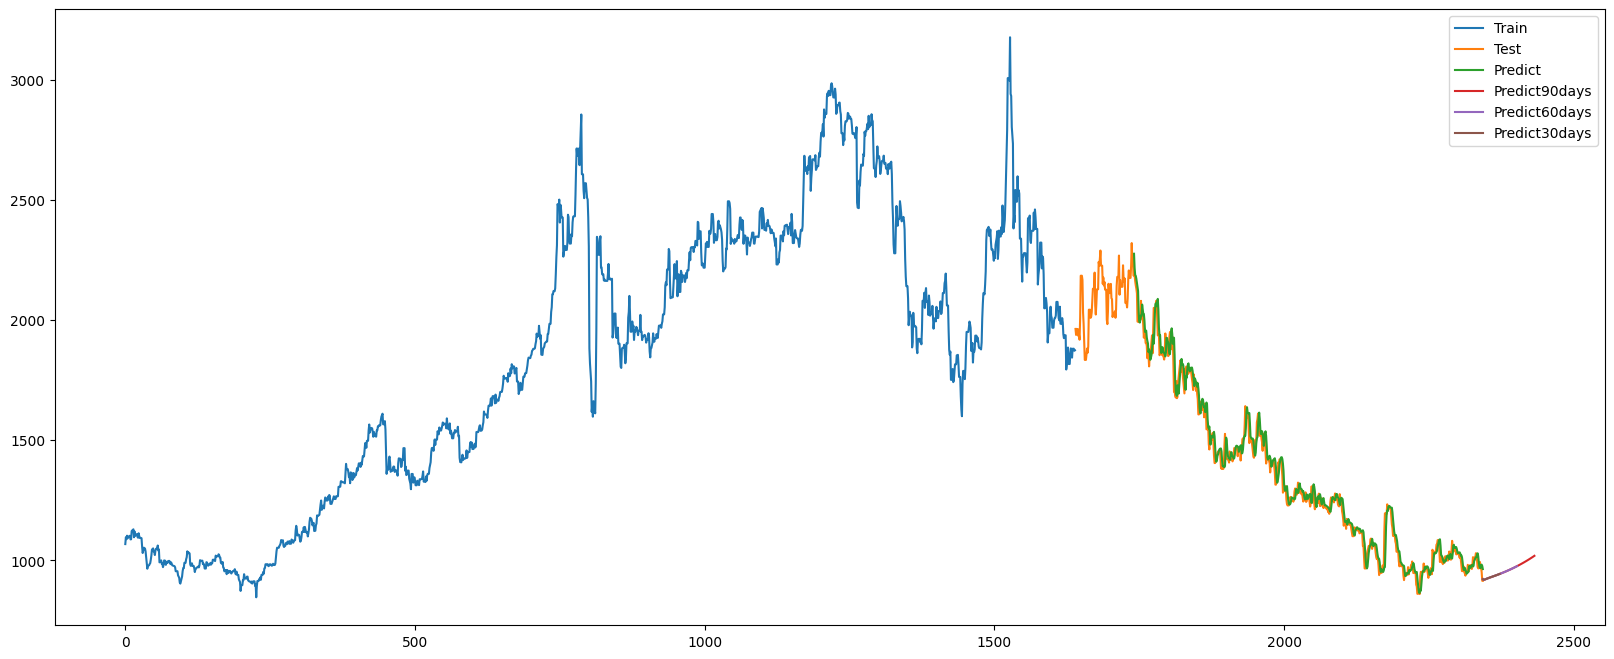

<Figure size 1600x900 with 0 Axes>

In [16]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
plt.figure(figsize=(16,9))
plt.show()